Let us look at the PSD of scans with and without HWP non-idealities.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import healpy as hp

from beamconv import Beam, ScanStrategy, tools

In [2]:
now = time.time()

In [3]:
lmax = 800
fname='../ancillary/wmap7_r0p03_lensed_uK_ext.txt'
cl_arr = np.loadtxt(fname, unpack=True)
ells = cl_arr[0]
cls = cl_arr[1:]
np.random.seed(10)
alm = hp.synalm(cls, lmax=lmax, new=True, verbose=True)

In [4]:
beam = Beam(btype='Gaussian', fwhm=32.2, lmax=lmax)
beam.hwp_mueller = np.diag([1, 1, -1, -1])

In [5]:
S = ScanStrategy(100, sample_rate=100, location='spole', ctime0=now) 
S.add_to_focal_plane(beam, combine=False)
S.set_hwp_mod(mode='continuous', freq=2.5)
S.scan_instrument_mpi(alm, save_tod=True, save_point=True, binning=False, scan_speed=0.1, interp=True, nside_spin=512)
tod_ideal = S.data(S.chunks[0], beam=beam, data_type='tod').copy()

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-10000


/Users/personal/.local/lib/python3.7/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |


In [6]:
beam2 = Beam(btype='Gaussian', fwhm=32.2, lmax=lmax)
beam2.hwp_mueller = np.asarray([[1, 1, 0, 0], [1, 1, 0, 0], [0, 0, -1, 0], [0, 0, 0, -1]], dtype=float)

In [7]:
S2 = ScanStrategy(100, sample_rate=100, location='spole', ctime0=now) 
S2.add_to_focal_plane(beam2, combine=False)
S2.set_hwp_mod(mode='continuous', freq=2.5)
S2.scan_instrument_mpi(alm, save_tod=True, save_point=True, binning=False, scan_speed=0.1, interp=True, nside_spin=512)
tod_nonideal = S2.data(S.chunks[0], beam=beam, data_type='tod').copy()

Scanning with 1 detectors
[rank 000]:	Working on chunk 000: samples 0-10000


In [8]:
hwp_freq = S.hwp_dict['freq']
fd = np.fft.rfft(tod_ideal)
fd2 = np.fft.rfft(tod_nonideal)
freqs = np.fft.rfftfreq(tod_ideal.size, d=1/S.fsamp)
psd_ideal = np.abs(fd) ** 2
psd_nonideal = np.abs(fd2) ** 2

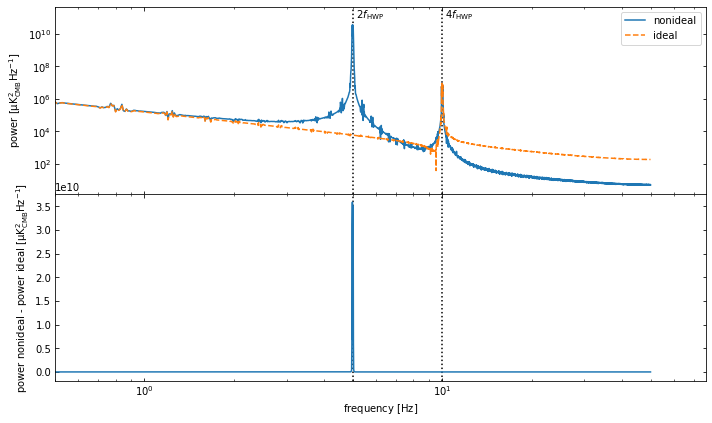

In [9]:
fig, axs = plt.subplots(nrows=2, figsize=(10,6), sharex=True)
for ax in axs.ravel():
    ax.axvline(4 * hwp_freq, color='black', linestyle=':')
    ax.axvline(2 * hwp_freq, color='black', linestyle=':')
    ax.tick_params(direction='in', right=True, top=True, which='both')

axs[0].set_ylabel('power [$\mathrm{\mu K_{CMB}^2 Hz^{-1}}$]')
axs[0].plot(freqs, psd_nonideal, label='nonideal')
axs[0].plot(freqs, psd_ideal, label='ideal', ls='--')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].annotate(r' $2f_{\mathrm{HWP}}$', (2 * hwp_freq , 1e11),
               xycoords='data')
axs[0].annotate(r' $4f_{\mathrm{HWP}}$', (4 * hwp_freq , 1e11),
               xycoords='data')

axs[1].set_ylabel('power nonideal - power ideal [$\mathrm{\mu K_{CMB}^2 Hz^{-1}}$]')
axs[1].plot(freqs, psd_nonideal - psd_ideal)
axs[1].set_xscale('log')
axs[1].set_xlim(0.2 * hwp_freq)

axs[1].set_xlabel('frequency [$\mathrm{Hz}$]')
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.show(fig)